In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import medfilt
class LSTMDFT(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMDFT, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                nn.Dropout(),
                                nn.Linear(hidden_size,output_size))

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, (h1, c1) = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [2]:
file_path = './data/ETTm2.csv'
data = pd.read_csv(file_path)
data.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 00:15:00,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000
2,2016-07-01 00:30:00,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002
3,2016-07-01 00:45:00,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001
4,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001


In [55]:
fs = 4

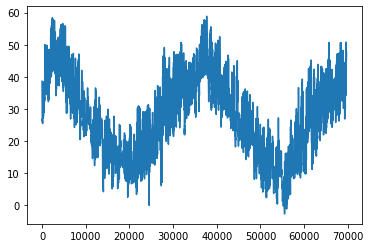

In [3]:
ot = data.values[:,-1].astype(np.float64)
plt.plot(ot)

In [45]:
class LSTMDataSet(Dataset):
    def __init__(self, 
                 data, 
                 seq_len,
                 pred_len, 
                 train=True, 
                 test_size=0.2):
        self.seq_len = seq_len
        self.pred_len = pred_len
        
       
        if train:
            self.data_, _, = train_test_split(data, test_size=test_size,shuffle=False)
        else:
            _, self.data_ = train_test_split(data, test_size=test_size,shuffle=False)
        self.data = self.data_.astype(np.float32)
        self.data_len = self.data.shape[0] - seq_len - pred_len - 1

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        X = self.dft(self.data[idx:idx+self.seq_len,-1])
        y = self.dft(self.data[idx+self.seq_len:idx+self.seq_len+self.pred_len,-1])
        return X, y
    def dft(self,series):
        dft_series = np.fft.fft(series)
        double_channel_series = np.stack((dft_series.real,dft_series.imag),axis=1)
        return double_channel_series
        

In [46]:
input_size = 7  # Example input size
hidden_size = 100
batch_size = 1024
seq_len = 96
pred_len = 96
lr = 1e-4
num_epochs = 1_000

trainset = LSTMDataSet(data=data.values[:,-1:],seq_len=seq_len,pred_len=pred_len,train=True)
testset = LSTMDataSet(data=data.values[:,-1:],seq_len=seq_len,pred_len=pred_len,train=False)
trainloader = DataLoader(trainset,batch_size=batch_size,shuffle=False)
testloader = DataLoader(testset,batch_size=batch_size,shuffle=False)

In [47]:
for bx,by in trainloader:
    break

In [52]:
bx.shape,by.shape

(torch.Size([1024, 96, 2]), torch.Size([1024, 96, 2]))

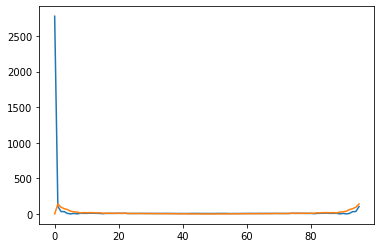

In [54]:
plt.plot(np.abs(bx[0]))